<a href="https://colab.research.google.com/github/shima2920/Kaggle/blob/main/Natural_Language_Processing_with_Disaster_Tweets%EF%BC%BF20210517.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
! pip install -q kaggle

from google.colab import files
files.upload()
#Kaggle account で発行した API token key ファイルを Upload する。

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list


Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-21 06:23:33           5912  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3295  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1166  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:0

In [96]:
!kaggle competitions download -c nlp-getting-started

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


# This is Kaggle Competition "Natural Language Processing with Disaster Tweets"

https://www.kaggle.com/c/nlp-getting-started/data

ref:https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

https://ailog.site/2021/04/05/2021/0405/


# **Summary** 

**05/17/2021**

In [97]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

# Check the data

In [98]:
tweet = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [99]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [100]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(tweet)[:25]


Dataset Shape: (7613, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,7613,1,4,5,12.89
1,keyword,object,61,221,NaN,NaN,NaN,7.77
2,location,object,2533,3341,NaN,NaN,NaN,11.06
3,text,object,0,7503,Our Deeds are the Reason of this #earthquake M...,Forest fire near La Ronge Sask. Canada,All residents asked to 'shelter in place' are ...,12.86
4,target,int64,0,2,1,1,1,0.99


In [101]:
tweet.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


# EDA

check the class ditribution for target column.

Text(0, 0.5, 'Count')

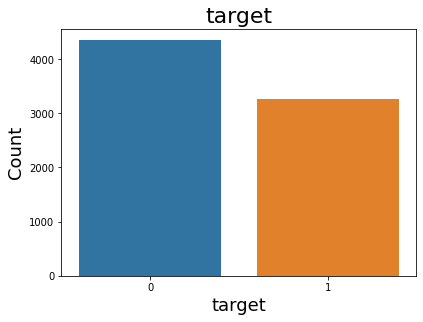

In [102]:
plt.figure(figsize=(14,10))
plt.subplot(221)
fig1 = sns.countplot(x='target', data=tweet, )
fig1.set_title("target", fontsize=22)
fig1.set_xlabel("target", fontsize=18)
fig1.set_ylabel('Count', fontsize=18)

Number of characters in tweets

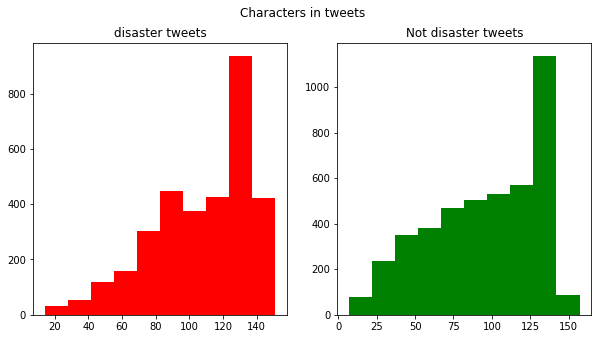

In [103]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

Number of words in a tweet

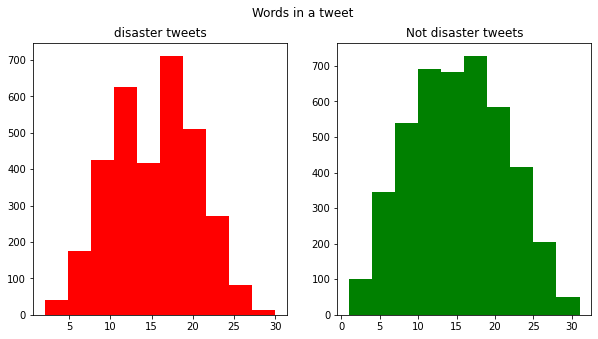

In [104]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Average word length in a tweet

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

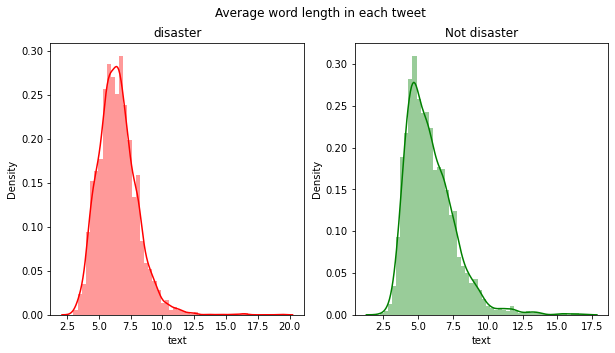

In [105]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [106]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [107]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [108]:
from collections import defaultdict
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

In [109]:
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

<BarContainer object of 10 artists>

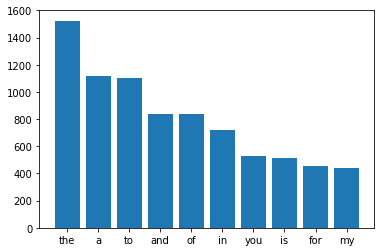

In [110]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

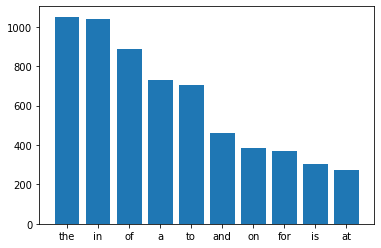

In [111]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

First let's check tweets indicating real disaster.

<BarContainer object of 18 artists>

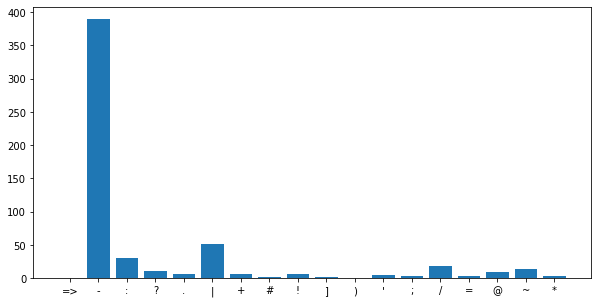

In [112]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

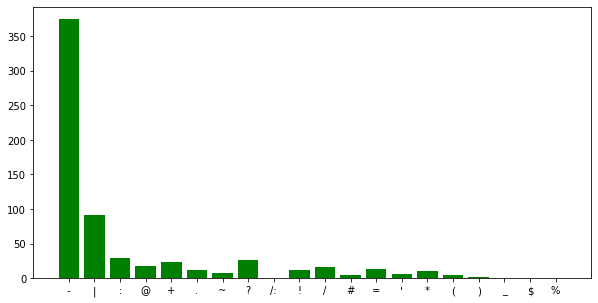

In [113]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [114]:
from collections import  Counter
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

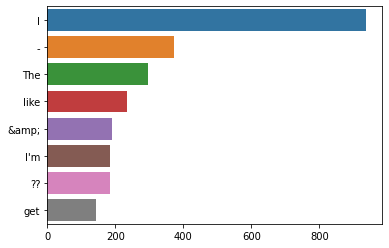

In [115]:
sns.barplot(x=y,y=x)

Ngram Analysis

we will do a bigram (n=2) analysis over the tweets.Let's check the most common bigrams in tweets.

In [116]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    print(vec)
    bag_of_words = vec.transform(corpus)
    print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print(sum_words)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
  (0, 2932)	1
  (0, 5238)	1
  (0, 19448)	1
  (0, 21677)	1
  (0, 25546)	1
  (0, 38297)	1
  (0, 43435)	1
  (0, 45009)	1
  (0, 48799)	1
  (0, 57892)	1
  (0, 59092)	1
  (0, 62611)	1
  (1, 24369)	1
  (1, 25509)	1
  (1, 35404)	1
  (1, 41036)	1
  (1, 50078)	1
  (1, 50799)	1
  (2, 2893)	1
  (2, 5087)	1
  (2, 5131)	1
  (2, 5773)	1
  (2, 7835)	1
  (2, 10297)	1
  (2, 22717)	1
  :	:
  (7611, 31857)	1
  (7611, 32866)	1
  (7611, 36281)	1
  (7611, 36773)	1
  (7611, 41911)	1
  (7611, 46937)	1
  (7611, 47102)	1
  (7611, 49684)	1
  (7611, 51733)	1
  (7611, 55121)	1
  (7611, 59431)	1
  (7611, 6601

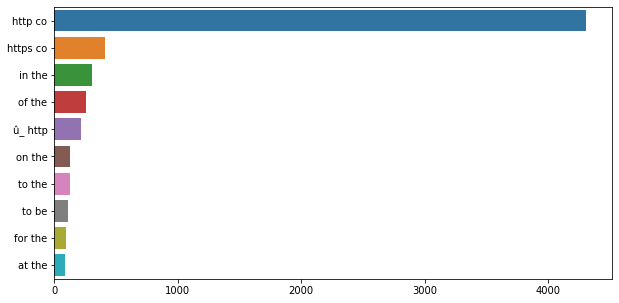

In [117]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [118]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Data Cleaning

As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [119]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

removing URLs

In [120]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [121]:
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [122]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

removing HTML Tag

In [123]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [124]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [125]:
df['text']=df['text'].apply(lambda x : remove_html(x))

Romoving Emojis

In [126]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [127]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

Removing punctuations

In [128]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [129]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

Spelling Correction

In [130]:
!pip install pyspellchecker

In [131]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese refeer this documennt"
correct_spellings(text)

'correct me plese refer this document'

GloVe for Vectorization

In [132]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]#isalphaメソッドは文字列中のすべての文字が英字で、かつ 1 文字以上ある場合に真を返す。かつ、ストップワードに入っていない単語が対象
        corpus.append(words)
    return corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [133]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7396.64it/s]


In [134]:
corpus

[['our', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['all',
  'residents',
  'asked',
  'shelter',
  'place',
  'notified',
  'officers',
  'no',
  'evacuation',
  'shelter',
  'place',
  'orders',
  'expected'],
 ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
 ['just',
  'got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfires',
  'pours',
  'school'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'directions',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfires'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'flooding',
  'streets',
  'manitou',
  'colorado',
  'springs',
  'areas'],
 ['im', 'top', 'hill', 'i', 'see', 'fire', 'woods'],
 ['theres',
  'emergency',
  'evacuation',
  'happening',
  'building',
  'across',
  'street'],
 ['im', 'afraid', 'tornado', 'coming', 'area'],
 ['three', 'people

Neural Network analysis with glove.6b

In [135]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        #print(values)
        word = values[0]
        #print(word)
        vectors = np.asarray(values[1:],'float32')
        #print(vectors)
        embedding_dict[word]  =vectors
f.close()

MAX_LEN = 50
tokenizer_obj = Tokenizer()#単語のベクトル化
tokenizer_obj.fit_on_texts(corpus)#単語のベクトル化
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')#pad_sequencesメソッドでは、要素の合わない配列に対して、0 で埋めることで配列のサイズを一致させています。
#paddingは前後どちらを埋めるか、truncatingは長いシーケンスの前後どちらを切り詰めるかを指定する引数

word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [152]:
tweet_pad.shape

(10876, 50)

In [153]:
word_index

{'i': 1,
 'the': 2,
 'like': 3,
 'amp': 4,
 'im': 5,
 'a': 6,
 'fire': 7,
 'get': 8,
 'new': 9,
 'via': 10,
 'news': 11,
 'people': 12,
 'one': 13,
 'in': 14,
 'dont': 15,
 'us': 16,
 'emergency': 17,
 'video': 18,
 'disaster': 19,
 'would': 20,
 'this': 21,
 'to': 22,
 'police': 23,
 'still': 24,
 'is': 25,
 'got': 26,
 'you': 27,
 'my': 28,
 'suicide': 29,
 'body': 30,
 'crash': 31,
 'burning': 32,
 'first': 33,
 'storm': 34,
 'rt': 35,
 'attack': 36,
 'time': 37,
 'back': 38,
 'know': 39,
 'california': 40,
 'fires': 41,
 'buildings': 42,
 'see': 43,
 'going': 44,
 'and': 45,
 'man': 46,
 'day': 47,
 'love': 48,
 'two': 49,
 'world': 50,
 'cant': 51,
 'bomb': 52,
 'if': 53,
 'nuclear': 54,
 'full': 55,
 'go': 56,
 'hiroshima': 57,
 'dead': 58,
 'youtube': 59,
 'watch': 60,
 'today': 61,
 'life': 62,
 'think': 63,
 'car': 64,
 'train': 65,
 'last': 66,
 'killed': 67,
 'it': 68,
 'accident': 69,
 'its': 70,
 'good': 71,
 'of': 72,
 'say': 73,
 'we': 74,
 'make': 75,
 'war': 76,
 'no':

In [136]:
tweet_pad

array([[ 622, 5467,  738, ...,    0,    0,    0],
       [  96,    7,  138, ...,    0,    0,    0],
       [ 119, 1469, 1386, ...,    0,    0,    0],
       ...,
       [ 749,  478,  348, ...,    0,    0,    0],
       [4085,  536,  372, ...,    0,    0,    0],
       [3997, 2557, 1462, ...,    0,    0,    0]], dtype=int32)

In [147]:
word_index

{'i': 1,
 'the': 2,
 'like': 3,
 'amp': 4,
 'im': 5,
 'a': 6,
 'fire': 7,
 'get': 8,
 'new': 9,
 'via': 10,
 'news': 11,
 'people': 12,
 'one': 13,
 'in': 14,
 'dont': 15,
 'us': 16,
 'emergency': 17,
 'video': 18,
 'disaster': 19,
 'would': 20,
 'this': 21,
 'to': 22,
 'police': 23,
 'still': 24,
 'is': 25,
 'got': 26,
 'you': 27,
 'my': 28,
 'suicide': 29,
 'body': 30,
 'crash': 31,
 'burning': 32,
 'first': 33,
 'storm': 34,
 'rt': 35,
 'attack': 36,
 'time': 37,
 'back': 38,
 'know': 39,
 'california': 40,
 'fires': 41,
 'buildings': 42,
 'see': 43,
 'going': 44,
 'and': 45,
 'man': 46,
 'day': 47,
 'love': 48,
 'two': 49,
 'world': 50,
 'cant': 51,
 'bomb': 52,
 'if': 53,
 'nuclear': 54,
 'full': 55,
 'go': 56,
 'hiroshima': 57,
 'dead': 58,
 'youtube': 59,
 'watch': 60,
 'today': 61,
 'life': 62,
 'think': 63,
 'car': 64,
 'train': 65,
 'last': 66,
 'killed': 67,
 'it': 68,
 'accident': 69,
 'its': 70,
 'good': 71,
 'of': 72,
 'say': 73,
 'we': 74,
 'make': 75,
 'war': 76,
 'no':

In [137]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))
print(embedding_matrix)
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 522637.26it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [138]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.75546998,  1.03649998,  0.10213   , ..., -0.17502999,
        -0.13342001,  0.14582001],
       [ 0.03458   , -0.48119   ,  0.67565   , ..., -0.42317   ,
         0.49230999, -0.20338   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Baseline Model


In [139]:
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])


In [140]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [141]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [142]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [143]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1618/1618 - 75s - loss: 0.6862 - accuracy: 0.5719 - val_loss: 0.6476 - val_accuracy: 0.5718
Epoch 2/15
1618/1618 - 69s - loss: 0.6048 - accuracy: 0.7000 - val_loss: 0.5661 - val_accuracy: 0.7715
Epoch 3/15
1618/1618 - 69s - loss: 0.5714 - accuracy: 0.7364 - val_loss: 0.5373 - val_accuracy: 0.7732
Epoch 4/15
1618/1618 - 70s - loss: 0.5494 - accuracy: 0.7455 - val_loss: 0.5128 - val_accuracy: 0.7802
Epoch 5/15
1618/1618 - 70s - loss: 0.5317 - accuracy: 0.7589 - val_loss: 0.4948 - val_accuracy: 0.7898
Epoch 6/15
1618/1618 - 70s - loss: 0.5213 - accuracy: 0.7651 - val_loss: 0.4838 - val_accuracy: 0.7960
Epoch 7/15
1618/1618 - 70s - loss: 0.5090 - accuracy: 0.7699 - val_loss: 0.4777 - val_accuracy: 0.7890
Epoch 8/15
1618/1618 - 70s - loss: 0.5046 - accuracy: 0.7710 - val_loss: 0.4682 - val_accuracy: 0.8004
Epoch 9/15
1618/1618 - 70s - loss: 0.5051 - accuracy: 0.7673 - val_loss: 0.4636 - val_accuracy: 0.8012
Epoch 10/15
1618/1618 - 70s - loss: 0.5013 - accuracy: 0.7713 - val_loss:

In [144]:
sample_sub=pd.read_csv('sample_submission.csv')

In [145]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [146]:
#Kaggle に API 経由で提出
!kaggle competitions submit nlp-getting-started -f submission.csv -m "First commit"

100% 22.2k/22.2k [00:06<00:00, 3.26kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets